In [18]:
import pandas as pd
import torch
import re
import numpy as np
from transformers import EsmTokenizer, EsmModel, AutoModelForSequenceClassification, AutoTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from torch import nn
from torch.utils.data import DataLoader, Dataset
from Bio.PDB import PDBParser
from Bio.Seq import Seq
from Bio.PDB.Polypeptide import PPBuilder
import os
from sklearn.preprocessing import StandardScaler
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from Bio.SeqUtils import seq1
from tqdm import tqdm

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


In [19]:
df = pd.read_csv("skempi_v2.csv",sep=';')  # should have: sequence, position, wild, mutant, ddg

# Load the ESM model and tokenizer from HuggingFace
#tokenizer = EsmTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
#model = EsmModel.from_pretrained("facebook/esm2_t6_8M_UR50D")
model = AutoModelForSequenceClassification.from_pretrained("esm2_ddg_finetuned")
tokenizer = AutoTokenizer.from_pretrained("esm2_ddg_finetuned")
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("\n")

In [10]:
def get_chain_sequence(pdb_id, chain_id):

    pdb_file = "PDBs/" + pdb_id + ".pdb"
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure(pdb_id, pdb_file)
    
    for model in structure:
        for chain in model:
            if chain.id == chain_id:
                ppb = PPBuilder()
                sequence = ""
                for pp in ppb.build_peptides(chain):
                    sequence += str(pp.get_sequence())
                return sequence
    return None
def get_esm_embedding(seq: str) -> torch.Tensor:
    """
    Generate mean-pooled embedding from a WT + [SEP] + MT sequence.

    Args:
        seq (str): Input sequence like "WT [SEP] MT"

    Returns:
        torch.Tensor: Mean-pooled embedding vector
    """
    inputs = tokenizer(seq, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model.base_model(**inputs, output_hidden_states=True)
        last_hidden = outputs.last_hidden_state  # [1, seq_len, hidden_dim]

        mask = inputs['attention_mask'].unsqueeze(-1)  # [1, seq_len, 1]
        masked = last_hidden * mask
        summed = masked.sum(dim=1)
        counts = mask.sum(dim=1)
        mean_embedding = (summed / counts).squeeze(0)  # Shape: [hidden_dim]

        return mean_embedding


In [20]:

def get_combined_features(wt_sequence, mutation, position, pdb_file, chain_id,wt):
    """Combine ESM embeddings with structure-based features."""
    # Parse mutation format

    wt = wt
    mt = mutation
    pos = position  # 1-indexed position


    
    # Apply mutation
    mt_sequence = wt_sequence[:pos-1] + mt + wt_sequence[pos:]
    full_seq = wt_sequence + " [SEP] " + mt_sequence
    # Generate ESM embeddings
    embedding_diff = get_esm_embedding(full_seq)
    
    # Get structure-based features
    # Combine all features
    structure_features = []
    
    # Add simple physicochemical features about the mutation
    # Hydrophobicity scale (Kyte-Doolittle)
    hydrophobicity = {
        'A': 1.8, 'R': -4.5, 'N': -3.5, 'D': -3.5, 'C': 2.5, 'Q': -3.5, 'E': -3.5,
        'G': -0.4, 'H': -3.2, 'I': 4.5, 'L': 3.8, 'K': -3.9, 'M': 1.9, 'F': 2.8,
        'P': -1.6, 'S': -0.8, 'T': -0.7, 'W': -0.9, 'Y': -1.3, 'V': 4.2
    }
    
    # Volume (Å³)
    volume = {
        'A': 88.6, 'R': 173.4, 'N': 114.1, 'D': 111.1, 'C': 108.5, 'Q': 143.8, 
        'E': 138.4, 'G': 60.1, 'H': 153.2, 'I': 166.7, 'L': 166.7, 'K': 168.6, 
        'M': 162.9, 'F': 189.9, 'P': 112.7, 'S': 89.0, 'T': 116.1, 'W': 227.8, 
        'Y': 193.6, 'V': 140.0
    }
    
    # Add mutation-specific features
    structure_features.append(hydrophobicity.get(wt, 0))
    structure_features.append(hydrophobicity.get(mt, 0))
    structure_features.append(hydrophobicity.get(mt, 0) - hydrophobicity.get(wt, 0))
    structure_features.append(volume.get(wt, 0))
    structure_features.append(volume.get(mt, 0))
    structure_features.append(volume.get(mt, 0) - volume.get(wt, 0))
    
    # Convert structure features to numpy array
    structure_features = np.array(structure_features, dtype=np.float32)
    
    # Combine with embedding difference
    combined_features = np.concatenate([embedding_diff, structure_features])
    
    return combined_features


In [21]:
feat = []
labels = []
print("Preprocessing...")
for idx, row in tqdm(df.iterrows()):
    if ',' in row['Mutation(s)_cleaned']:
        continue
    pdb_id = row['#Pdb'][0:4]
    chain_id = row['Mutation(s)_cleaned'][1]
    sequence = get_chain_sequence(pdb_id, chain_id)
    #break
    
    position = re.search(r'[A-Za-z](\d+)[A-Za-z]', row['Mutation(s)_cleaned']).group(1)
    pos = int(position)

    
    pdb_file = "PDBs/" + pdb_id + ".pdb"


    feature_vector = get_combined_features(sequence,row['Mutation(s)_cleaned'][-1],pos,pdb_file,chain_id,row['Mutation(s)_cleaned'][0])
    ddg = ((8.314/4184)*(273.15 + 25.0)* np.log(row['Affinity_mut_parsed'])) - ((8.314/4184)*(273.15 + 25.0)* np.log(row['Affinity_wt_parsed']))
    if pd.isna(ddg):
        ddg = 0
    
    

    feat.append(feature_vector)
    labels.append(ddg)
print("Preprocessing finished...")

Preprocessing...


0it [00:00, ?it/s]Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
7085it [08:57, 13.18it/s] 

Preprocessing finished...


In [22]:
X = np.array(feat)
y = np.array(labels)
print(y.shape)
print(df.shape)

(5112,)
(7085, 29)


In [23]:
class DdGDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Deep learning model
class DdGPredictor(nn.Module):
    def __init__(self, input_dim):
        super(DdGPredictor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256), 
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),  
            nn.Linear(64, 1)
        )
    
    def forward(self, x):
        return self.model(x)
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50, clip_value=1.0):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_model_state = None
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        for features, labels in train_loader:
            features = features.to(device)
            
            labels = labels.to(device)
            
            
            optimizer.zero_grad()
            outputs = model(features)
            
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        train_loss = running_loss / len(train_loader)

        train_losses.append(train_loss)
        
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for features, labels in val_loader:
                
                features = features.to(device)
                labels = labels.to(device)
                outputs = model(features)
                loss = criterion(outputs.squeeze(), labels)
                val_loss += loss.item()
        
        val_loss = val_loss / len(val_loader)
        val_losses.append(val_loss)
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.8f}, Val Loss: {val_loss:.8f}')
    
    # Load best model
    model.load_state_dict(best_model_state)
    return model, train_losses, val_losses

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=12)

326
Training model...
Epoch 1/100, Train Loss: 4.04947816, Val Loss: 3.65061218
Epoch 2/100, Train Loss: 3.70993564, Val Loss: 3.50235111
Epoch 3/100, Train Loss: 3.48804654, Val Loss: 3.38409820
Epoch 4/100, Train Loss: 3.24616454, Val Loss: 3.18905056
Epoch 5/100, Train Loss: 3.09441082, Val Loss: 3.19294869
Epoch 6/100, Train Loss: 2.97705511, Val Loss: 3.02946521
Epoch 7/100, Train Loss: 2.88011429, Val Loss: 2.87111412
Epoch 8/100, Train Loss: 2.76133847, Val Loss: 2.82833495
Epoch 9/100, Train Loss: 2.63312103, Val Loss: 2.73910119
Epoch 10/100, Train Loss: 2.54585663, Val Loss: 2.68423466
Epoch 11/100, Train Loss: 2.49656888, Val Loss: 2.52347920
Epoch 12/100, Train Loss: 2.43842822, Val Loss: 2.48179908
Epoch 13/100, Train Loss: 2.36199967, Val Loss: 2.41138257
Epoch 14/100, Train Loss: 2.33529360, Val Loss: 2.40575065
Epoch 15/100, Train Loss: 2.23587791, Val Loss: 2.29539730
Epoch 16/100, Train Loss: 2.20200252, Val Loss: 2.35560662
Epoch 17/100, Train Loss: 2.11411486, Val L

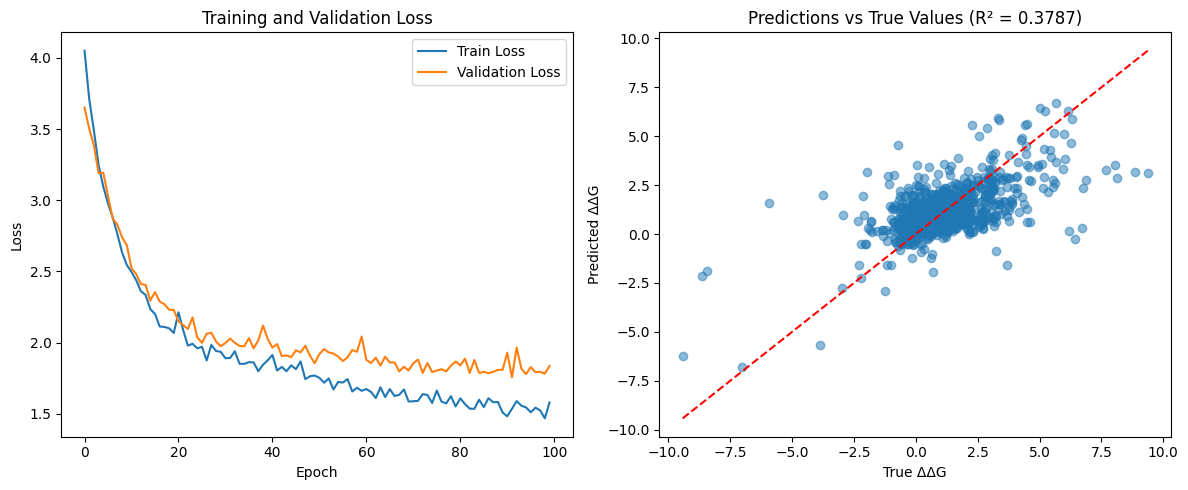

In [25]:

    
    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    # Create dataloaders
    train_dataset = DdGDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
    val_dataset = DdGDataset(torch.FloatTensor(X_val), torch.FloatTensor(y_val))
    test_dataset = DdGDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test))
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    # Initialize model
    input_dim = X_train.shape[1]  # ESM embedding dimension
    print(input_dim)
    model = DdGPredictor(input_dim).to(device)
    
    # Loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-6)
    
    # Train model
    print("Training model...")
    model, train_losses, val_losses = train_model(
        model, train_loader, val_loader, criterion, optimizer, num_epochs=100
    )
    
    # Evaluate model
    print("Evaluating model...")
    model.eval()
    y_pred = []
    y_true = []
    
    with torch.no_grad():
        for features, labels in test_loader:
            features = features.to(device)
            outputs = model(features)
            predictions = outputs.squeeze().cpu().numpy()
            y_pred.extend(predictions)
            y_true.extend(labels.numpy())
    
    # Calculate metrics
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    print(f"Test Results:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R^2: {r2:.4f}")
    
    # Plot results
    plt.figure(figsize=(12, 5))
    
    # Plot loss curves
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    
    # Plot predictions vs true values
    plt.subplot(1, 2, 2)
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
    plt.xlabel('True ΔΔG')
    plt.ylabel('Predicted ΔΔG')
    plt.title(f'Predictions vs True Values (R² = {r2:.4f})')
    
    plt.tight_layout()
    plt.savefig('ddg_prediction_results.png')
    plt.show()

In [26]:
import pickle

# Save the model and scaler
torch.save({
    'model_state_dict': model.state_dict(),
    'input_dim': input_dim,
    'hidden_dim': 256
}, 'ddg_predictor_model_new.pth')

with open('ddg_scaler_new.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("Model and scaler saved successfully")

Model and scaler saved successfully
